In [184]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import numpy as np

In [185]:
def plot_data(X, y, ds_num):
    # Separate the points based on the labels so that we can plot the figure in a color blind friendly manner.
    X_neg = X[np.array(y) == 0]
    X_pos = X[np.array(y) == 1]
    
    # Plot the points with different markers.
    plt.scatter(X_neg[:, 0], X_neg[:, 1], c='indigo', marker='x', label='0')
    plt.scatter(X_pos[:, 0], X_pos[:, 1], c='gold', marker='o', label='1')
    
    plt.title(f"Dataset {ds_num}")
    plt.legend()
    plt.savefig(f'image/dataset_{ds_num}.jpg')
    plt.show() 

Looks separable using a linear function

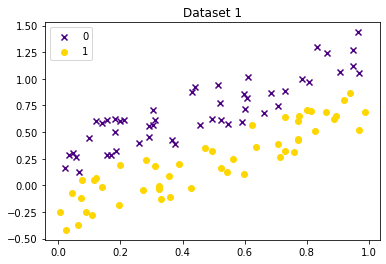

In [186]:
n_samples=100

def generate_X_lin(num_points=100, x_center=0.5, seed=42):
    np.random.seed(seed)  # Set the seed for reproducibility
    assert num_points % 2 == 0, "Number of points must be even."
    half_points = num_points // 2
    
    # Generate x-values around the center
    x_values_above = np.random.rand(half_points) + x_center - 0.5
    x_values_below = np.random.rand(half_points) + x_center - 0.5
    
    # Calculate y-values based on the linear function y = x with random noise
    y_values_above = x_values_above + np.random.rand(half_points) * 0.5
    y_values_below = x_values_below - np.random.rand(half_points) * 0.5
    
    # Combine x and y values
    X_lin_above = np.vstack((x_values_above, y_values_above)).T
    X_lin_below = np.vstack((x_values_below, y_values_below)).T
    
    return np.vstack((X_lin_above, X_lin_below))

# Generate the data
X_lin = generate_X_lin(num_points=n_samples, x_center=0.5)

y_lin_0 = [0 for _ in range(n_samples//2)]
y_lin_1 = [1 for _ in range(n_samples//2)]
y_lin = y_lin_0 + y_lin_1

plot_data(X_lin, y_lin, 1)

Looks separable using a polynomial function of degree 3

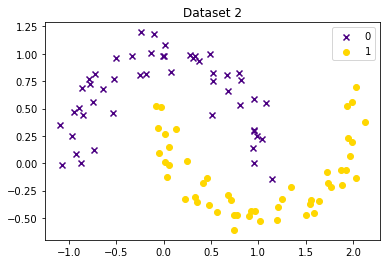

In [187]:
from sklearn.datasets import make_moons
  
X_poly, y_poly = make_moons(n_samples=100, noise=0.1) 
plot_data(X_poly, y_poly, 2)

Looks separable using a gaussian function of in 3 dimension

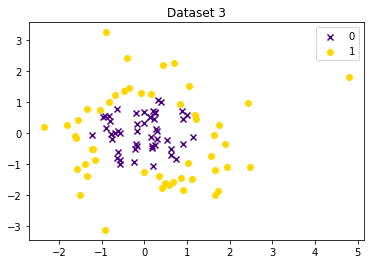

In [188]:
from sklearn.datasets import make_gaussian_quantiles 
  
X_gaus, y_gaus = make_gaussian_quantiles(n_samples=100, cov=1, n_features=2, n_classes=2, random_state=55)
plot_data(X_gaus, y_gaus, 3)

Looks separable using a tanh function

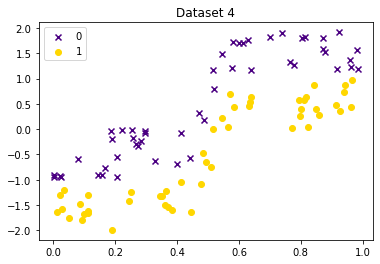

In [189]:
n_samples=100

def generate_X_tanh(num_points=100, x_center=0.5, steepness=25, seed=5): 
    np.random.seed(seed) # seed is used to not change the plot after every generation
    assert num_points % 2 == 0, "num_points must be even."
    half_points = num_points // 2
    
    # Generate x-values around the center
    x_values_above = np.random.rand(half_points) + x_center - 0.5
    x_values_below = np.random.rand(half_points) + x_center - 0.5
    
    # Calculate y-values based on the tanh function with increased steepness
    y_values_above = np.tanh(steepness * (x_values_above - x_center)) + np.random.rand(half_points) 
    y_values_below = np.tanh(steepness * (x_values_below - x_center)) - np.random.rand(half_points) 
    
    # Combine x and y values
    X_tanh_above = np.vstack((x_values_above, y_values_above)).T
    X_tanh_below = np.vstack((x_values_below, y_values_below)).T
    
    return np.vstack((X_tanh_above, X_tanh_below))

# Generate the data
X_tanh = generate_X_tanh(n_samples, x_center=0.5)

y_tanh_0 = [0 for _ in range(n_samples//2)]
y_tanh_1 = [1 for _ in range(n_samples//2)]
y_tanh = y_tanh_0 + y_tanh_1

plot_data(X_tanh, y_tanh, 4)

Get the gamma value that correspond to the value of default gamma when using sklearn SVC.
"If gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma"

In [190]:
def get_gamma(train_image):
    n_features = len(train_image[0])
    gamma = 1/(train_image.var()*n_features)

    return gamma

gamma_poly = get_gamma(X_poly)
gamma_gaus = get_gamma(X_gaus)
gamma_tanh = get_gamma(X_tanh)

sigma_gaus = np.sqrt(1/(2*gamma_gaus))

Define the functions (default hyperparameters used)

In [191]:
def linear_func(x):
    return x

def poly_func(x, gamma=gamma_poly, coef0=0, degree=3):
    return (gamma_poly*x+coef0)**degree

def rbf_func(x, sigma=sigma_gaus): 
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*(x**2/sigma**2))

def sigmoid_func(x):
    return 1/(1+np.exp(-x))

In [192]:
def norm(v):
    return np.sqrt(np.inner(v,v))

def sum_angle_diff_label(func, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    inner_product_list =[]

    # calculate the "cos of the angle" (let's call it C) between data points with different label 
    # If C is a big number, angle is small indicating a bad separation 
    # (since cosine is a monotonically decreasing function between angle=0 and angle=pi).
    for i in index_label_zero: 
        for j in index_label_one:
            inner_product = np.inner(func(dataset_img[i]), func(dataset_img[j]))
            normalized_inner_product = inner_product/(norm(func(dataset_img[i]))*norm(func(dataset_img[j])))
            inner_product_list.append(normalized_inner_product)
            
    # we will sum the value of each inner product between two differently labeled data points 
    return sum(inner_product_list)


In [193]:
# Creating a 4x4 DataFrame
data_angl_diff_label = {
    'linear kernel': [sum_angle_diff_label(linear_kernel, X_lin, y_lin), sum_angle_diff_label(linear_kernel, X_poly, y_poly), sum_angle_diff_label(linear_kernel, X_gaus, y_gaus), sum_angle_diff_label(linear_kernel, X_tanh, y_tanh)],
    'polynomial kernel': [sum_angle_diff_label(poly_kernel, X_lin, y_lin), sum_angle_diff_label(poly_kernel, X_poly, y_poly), sum_angle_diff_label(poly_kernel, X_gaus, y_gaus), sum_angle_diff_label(poly_kernel, X_tanh, y_tanh)],
    'RBF kernel': [sum_angle_diff_label(rbf_kernel, X_lin, y_lin), sum_angle_diff_label(rbf_kernel, X_poly, y_poly), sum_angle_diff_label(rbf_kernel, X_gaus, y_gaus), sum_angle_diff_label(rbf_kernel, X_tanh, y_tanh)],
    'sigmoid kernel': [sum_angle_diff_label(sigmoid_kernel, X_lin, y_lin), sum_angle_diff_label(sigmoid_kernel, X_poly, y_poly), sum_angle_diff_label(sigmoid_kernel, X_gaus, y_gaus), sum_angle_diff_label(sigmoid_kernel, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_angl_diff_label = pd.DataFrame(data_angl_diff_label, index=index_labels)

print("Dataframe for sum of inner product between different labeled data points:")
print(df_angl_diff_label)

Dataframe for sum of inner product between different labeled data points:
           linear kernel  polynomial kernel   RBF kernel  sigmoid kernel
Dataset 1    1368.316703         691.050270  2483.652605     2485.961417
Dataset 2    -123.176052           7.670565  2331.197247     2304.149565
Dataset 3     -11.432603          -3.436998  2268.398084     2257.615925
Dataset 4     573.035880         244.612873  2390.047435     2371.368018


Plotting the dataframe

In [194]:
# preparation for color blind friendly plots

blue_o = mlines.Line2D([], [], color='#1f77b4', marker='o',
                          markersize=8, label='linear kernel')
orange_x = mlines.Line2D([''], [], color='#ff7f0e', marker='x',
                          markersize=8, label='polynomial kernel')
green_dia = mlines.Line2D([], [], color='#2ca02c', marker='D',
                          markersize=6, label='RBF kernel')
red_tri = mlines.Line2D([], [], color='#d62728', marker='^',
                          markersize=8, label='sigmoid kernel')

markers = ["o", "x", "D", "^"]

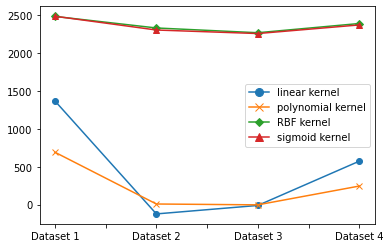

In [195]:
plot_angl_diff = df_angl_diff_label.plot.line() #(title="Plot A") # inner products between points of different labels/classes (bigger the better)

for i, line in enumerate(plot_angl_diff.get_lines()):
    line.set_marker(markers[i])

plot_angl_diff.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_angl_diff_1 = plot_angl_diff.figure
plot_angl_diff_1.savefig(f'image/plot_angl_diff_1.jpg')

In [196]:
plot_angl_diff.set_ylim([-250,1300]) # disregarding the outlier which was too low
plot_angl_diff_2 = plot_angl_diff.figure
plot_angl_diff_2.savefig(f'image/plot_angl_diff_2.jpg') 

Now, the inner product between data points of the same classes

In [197]:
def sum_angl_same_label(func, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    # print(f"zeros:{index_label_zero}")
    # print(f"ones{index_label_one}")
    inner_product_list =[]

    # calculate the "cos of the angle" (let's call it C) between data points with same label 
    # If C is a big number, angle is small indicating a good separation 
    # (since cosine is a monotonically decreasing function between angle=0 and angle=pi).
    for i in index_label_zero: 
        for j in index_label_zero:
            inner_product = np.inner(func(dataset_img[i]), func(dataset_img[j]))
            normalized_inner_product = inner_product/(norm(func(dataset_img[i]))*norm(func(dataset_img[j])))
            inner_product_list.append(normalized_inner_product)
            
    for i in index_label_one: 
        for j in index_label_one:
            inner_product = np.inner(func(dataset_img[i]), func(dataset_img[j]))
            normalized_inner_product = inner_product/(norm(func(dataset_img[i]))*norm(func(dataset_img[j])))
            inner_product_list.append(normalized_inner_product)

    # we will sum the value of each inner product between two differently labeled data points 
    return sum(inner_product_list)

In [198]:
# Creating a 4x4 DataFrame
data_angl_same_label = {
    'linear func': [sum_angle_same_label(linear_func, X_lin, y_lin), sum_angle_same_label(linear_func, X_poly, y_poly), sum_angl_same_label(linear_func, X_gaus, y_gaus), sum_angle_same_label(linear_func, X_tanh, y_tanh)],
    'polynomial func': [sum_angle_same_label(poly_func, X_lin, y_lin), sum_angle_same_label(poly_func, X_poly, y_poly), sum_angle_same_label(poly_func, X_gaus, y_gaus), sum_angle_same_label(poly_func, X_tanh, y_tanh)],
    'RBF func': [sum_angle_same_label(rbf_func, X_lin, y_lin), sum_angle_same_label(rbf_func, X_poly, y_poly), sum_angle_same_label(rbf_func, X_gaus, y_gaus), sum_angle_same_label(rbf_func, X_tanh, y_tanh)],
    'sigmoid func': [sum_angle_same_label(sigmoid_func, X_lin, y_lin), sum_angle_same_label(sigmoid_func, X_poly, y_poly), sum_angle_same_label(sigmoid_func, X_gaus, y_gaus), sum_angle_same_label(sigmoid_func, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_angl_same_label = pd.DataFrame(data_angl_same_label, index=index_labels)

print("Dataframe for sum of inner product between same labeled data points:")
print(df_angl_same_label)

Dataframe for sum of inner product between same labeled data points:
           linear func  polynomial func     RBF func  sigmoid func
Dataset 1  4031.433245      4045.294243  4989.593611   4995.399915
Dataset 2  2482.787517      2397.476643  4797.567875   4880.039923
Dataset 3    25.398230        15.672287  4553.809413   4537.098688
Dataset 4  1514.011486      1219.981279  4783.543418   4845.529980


Plotting the dataframe

In [199]:
# preparation for color blind friendly plots

blue_o = mlines.Line2D([], [], color='#1f77b4', marker='o',
                          markersize=8, label='linear kernel')
orange_x = mlines.Line2D([], [], color='#ff7f0e', marker='x',
                          markersize=8, label='polynomial kernel')
green_dia = mlines.Line2D([], [], color='#2ca02c', marker='D',
                          markersize=6, label='RBF kernel')
red_tri = mlines.Line2D([], [], color='#d62728', marker='^',
                          markersize=8, label='sigmoid kernel')

markers = ["o", "x", "D", "^"]

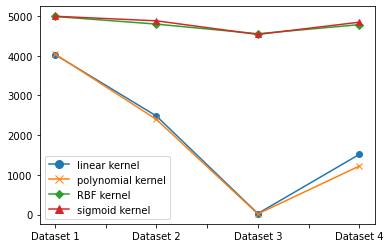

In [200]:
plot_angl_same = df_angl_same_label.plot.line() #(title="Plot B") # inner products between points of different labels/classes (smaller the better)

for i, line in enumerate(plot_angl_same.get_lines()):
    line.set_marker(markers[i])

plot_angl_same.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_angl_same=plot_angl_same.figure
plot_angl_same.savefig(f'image/plot_angl_same.jpg')

Criterion 2: Distance between data points

In [201]:
def sum_dis_diff_label(func, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    inner_product_list =[]

    # calculate the "cos of the angle" (let's call it C) between data points with different label 
    # If C is a big number, angle is small indicating a bad separation 
    # (since cosine is a monotonically decreasing function between angle=0 and angle=pi).
    for i in index_label_zero: 
        for j in index_label_one:
            inner_product = norm(func(dataset_img[i])-func(dataset_img[j]))
            inner_product_list.append(inner_product)
            
    # we will sum the value of each inner product between two differently labeled data points 
    return sum(inner_product_list)

In [202]:
# Creating a 4x4 DataFrame
data_dis_diff_label = {
    'linear func': [sum_dis_diff_label(linear_func, X_lin, y_lin), sum_dis_diff_label(linear_func, X_poly, y_poly), sum_dis_diff_label(linear_func, X_gaus, y_gaus), sum_dis_diff_label(linear_func, X_tanh, y_tanh)],
    'polynomial func': [sum_dis_diff_label(poly_func, X_lin, y_lin), sum_dis_diff_label(poly_func, X_poly, y_poly), sum_dis_diff_label(poly_func, X_gaus, y_gaus), sum_dis_diff_label(poly_func, X_tanh, y_tanh)],
    'RBF func': [sum_dis_diff_label(rbf_func, X_lin, y_lin), sum_dis_diff_label(rbf_func, X_poly, y_poly), sum_dis_diff_label(rbf_func, X_gaus, y_gaus), sum_dis_diff_label(rbf_func, X_tanh, y_tanh)],
    'sigmoid func': [sum_dis_diff_label(sigmoid_func, X_lin, y_lin), sum_dis_diff_label(sigmoid_func, X_poly, y_poly), sum_dis_diff_label(sigmoid_func, X_gaus, y_gaus), sum_dis_diff_label(sigmoid_func, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_dis_diff_label = pd.DataFrame(data_dis_diff_label, index=index_labels)

print("Dataframe for sum of inner product between same labeled data points:")
print(df_dis_diff_label)

Dataframe for sum of inner product between same labeled data points:
           linear func  polynomial func    RBF func  sigmoid func
Dataset 1  1708.265658      1309.366210  199.956375    397.302018
Dataset 2  3863.797089      6275.557764  353.898453    851.058784
Dataset 3  5020.481993     16893.372731  535.308569   1017.901950
Dataset 4  3793.632947      7209.273808  335.268753    805.183126


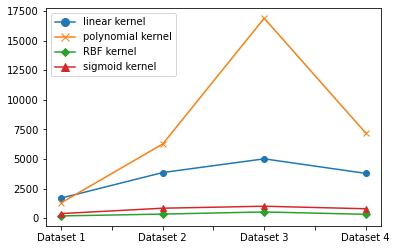

In [203]:
plot_dis_diff = df_dis_diff_label.plot.line() #(title="Plot A") # inner products between points of different labels/classes (bigger the better)

for i, line in enumerate(plot_dis_diff.get_lines()):
    line.set_marker(markers[i])

plot_dis_diff.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_dis_diff = plot_dis_diff.figure
plot_dis_diff.savefig(f'image/plot_dis_diff.jpg')

Now the distance between the same labeled data points

In [204]:
def sum_dis_same_label(func, dataset_img, dataset_label):

    index_label_zero = []
    index_label_one = []

    # find the index of the dataset which has label 0 and label 1
    for i in range(0,100):
        if dataset_label[i] == 0:
            index_label_zero.append(i)
        else:
            index_label_one.append(i)

    # print(index_label_zero)
    inner_product_list =[]

    # calculate the "cos of the angle" (let's call it C) between data points with same label 
    # If C is a big number, angle is small indicating a good separation 
    # (since cosine is a monotonically decreasing function between angle=0 and angle=pi).
    for i in index_label_zero: 
        for j in index_label_zero:
            inner_product = norm(func(dataset_img[i])-func(dataset_img[j]))
            inner_product_list.append(inner_product)
            
    for i in index_label_one: 
        for j in index_label_one:
            inner_product = norm(func(dataset_img[i])-func(dataset_img[j]))
            inner_product_list.append(inner_product)

    # we will sum the value of each inner product between two differently labeled data points 
    return sum(inner_product_list)

In [205]:
# Creating a 4x4 DataFrame
data_dis_same_label = {
    'linear func': [sum_dis_same_label(linear_func, X_lin, y_lin), sum_dis_same_label(linear_func, X_poly, y_poly), sum_dis_same_label(linear_func, X_gaus, y_gaus), sum_dis_same_label(linear_func, X_tanh, y_tanh)],
    'polynomial func': [sum_dis_same_label(poly_func, X_lin, y_lin), sum_dis_same_label(poly_func, X_poly, y_poly), sum_dis_same_label(poly_func, X_gaus, y_gaus), sum_dis_same_label(poly_func, X_tanh, y_tanh)],
    'RBF func': [sum_dis_same_label(rbf_func, X_lin, y_lin), sum_dis_same_label(rbf_func, X_poly, y_poly), sum_dis_same_label(rbf_func, X_gaus, y_gaus), sum_dis_same_label(rbf_func, X_tanh, y_tanh)],
    'sigmoid func': [sum_dis_same_label(sigmoid_func, X_lin, y_lin), sum_dis_same_label(sigmoid_func, X_poly, y_poly), sum_dis_same_label(sigmoid_func, X_gaus, y_gaus), sum_dis_same_label(sigmoid_func, X_tanh, y_tanh)]
}
 
index_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
 
df_dis_same_label = pd.DataFrame(data_dis_same_label, index=index_labels)

print("Dataframe for sum of inner product between same labeled data points:")
print(df_dis_same_label)

Dataframe for sum of inner product between same labeled data points:
           linear func  polynomial func    RBF func  sigmoid func
Dataset 1  2575.149630      2133.781167  319.840766    598.016844
Dataset 2  4876.358983      8732.099216  543.108500   1065.584006
Dataset 3  8845.018934     28690.845038  646.610235   1828.380179
Dataset 4  5993.743853     10243.778094  621.473132   1299.662169


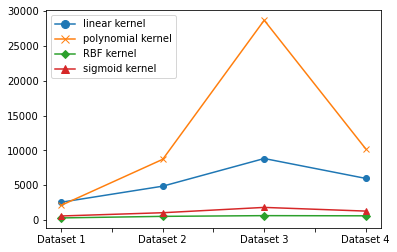

In [206]:
plot_dis_same = df_dis_same_label.plot.line() #(title="Plot B") # inner products between points of different labels/classes (smaller the better)

for i, line in enumerate(plot_dis_same.get_lines()):
    line.set_marker(markers[i])

plot_dis_same.legend(handles=[blue_o, orange_x, green_dia, red_tri])

# save figure
plot_dis_same=plot_dis_same.figure
plot_dis_same.savefig(f'image/plot_dis_same.jpg')